In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load data 

In [2]:
# import acceleromter data
# data = np.genfromtxt(r'data/300_steps_in_pocket-2021-00-11_11-24-20/Accelerometer.csv',delimiter=',',skip_header=1)
# data = data[:,1:]
data = np.genfromtxt(r'data\300_steps\300 in hand with fake__1.txt',delimiter=',',skip_header=25)
data = data[:,:-1]


sample_rate = 20/1000 # rate in seconds

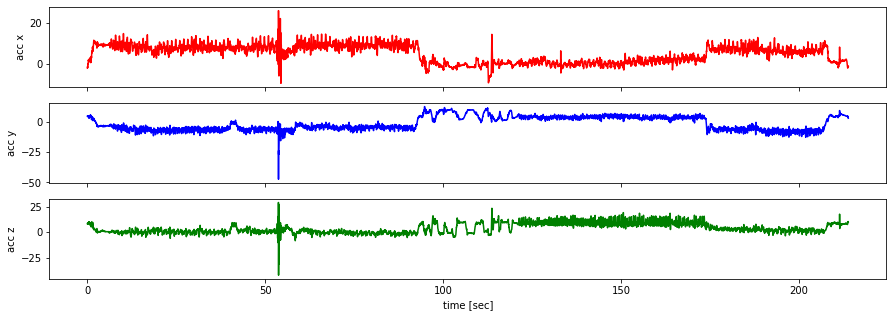

In [3]:
# plot accelerations data in each axes
fig, axs = plt.subplots(nrows=3, ncols=1,sharex=True, figsize=(15,5))

axs[0].plot(np.arange(len(data))*sample_rate,data[:,0],'-r')
axs[0].set_ylabel('acc x')

axs[1].plot(np.arange(len(data))*sample_rate,data[:,1],'-b')
axs[1].set_ylabel('acc y')

axs[2].plot(np.arange(len(data))*sample_rate,data[:,2],'-g')
axs[2].set_ylabel('acc z')

axs[2].set_xlabel('time [sec]')


plt.show()

## Preprocessing

In [4]:
# remove first and last 5 seconds
data = data[250:-250]
# compute combined acceleromter magnitude
data = np.sqrt(data[:,0]**2 + data[:,1]**2 + data[:,2]**2)

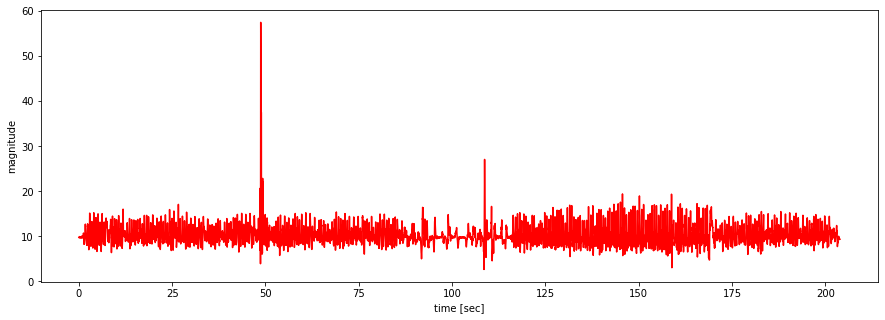

In [5]:
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(data))*sample_rate,data,'-r')
plt.ylabel('magnitude')
plt.xlabel('time [sec]')
plt.show()

## We will compare between basic threshold steps counter to the proposed rubustStepCounter

### Methods functions

In [6]:
def thresholdStepCounter(data, sample_rate, peak_threshold, peaks_min_distance, first_index):
    
    peaks_min_distance_flag = True
    time_from_last_peak = peaks_min_distance+1 # we initialize it to be greater then min distance 
    steps_counter = 0
    peaks =[]

    for i in range(first_index, data.shape[0]):

        if data[i] > peak_threshold and peaks_min_distance_flag:
            steps_counter +=1
            peaks.append(i)
            time_from_last_peak = 0 
            
        time_from_last_peak += sample_rate
        peaks_min_distance_flag = time_from_last_peak >= peaks_min_distance
        
    steps = np.asarray(peaks) # first N peaks and the last peak are not counted (to compare with the robust )
    return steps

In [7]:
def robustStepCounter(data, sample_rate, K, M, N, T_max, T_min, sim_threshold, var_threshold):
    # peak detection
    peaks = peak_detector(data,K)
    # # plot result
    # fig = plt.figure(figsize=(15,5))
    # plt.plot(np.arange(len(data))*sample_rate,data,'-r')
    # plt.scatter(peaks*sample_rate,data[peaks])
    # plt.ylabel('acceleration magnitude')
    # plt.xlabel('time [sec]')
    # plt.title(str(len(peaks)) + ' peaks detected')
    # plt.show()
    steps = []
    steps_count = 0
    countinuities =[]
    similarities =[]
    periodicities =[]

    first_index = peaks[N-1] # for comparison with threshold method
    for i in range(N-1,len(peaks)-1):
        
        C = calculate_continuity(i,data,peaks,M,N,var_threshold)
        # # prints for debug
        # print('continuity: ',C)
        # print('similarity: ',calculate_similarity(data,i,peaks))
        # print('periodicity: ',calculate_periodicity(i,peaks,sample_rate))
        # #
        if C == 0: 
            countinuities.append(peaks[i])
            continue
        elif calculate_similarity(data,i,peaks)<=sim_threshold:
            similarities.append(peaks[i])
            continue
        elif T_min<calculate_periodicity(i,peaks,sample_rate)<T_max:
            steps_count +=1
            steps.append(peaks[i])
        else:
            periodicities.append(peaks[i])

    steps = np.asarray(steps)
    return steps, peaks , np.asarray(countinuities), np.asarray(similarities), np.asarray(periodicities), first_index

In [8]:
def peak_detector(data, K):
    
    peaks =[]

    for i, datum in enumerate(data):
        if i > 0:
            if i-K < 0 :
            
                if datum >= max(data[:i]) and datum >=max(data[i+1:i+K+1]):
                    peaks.append(i)

            elif i+K > len(data) :

                if datum >= max(data[i-K:i]) and datum >=max(data[i+1:]):
                    peaks.append(i)
            else :

                if datum >= max(data[i-K:i]) and datum >=max(data[i+1:i+K+1]):
                        peaks.append(i)
                        time_from_last_peak = 0 



    return np.asarray(peaks)

In [9]:
def calculate_continuity(i,data,peaks,M,N,var_threshold):
    # determine continuity 
    sum = 0
    for j in range(i-N+1,i+1):
        var = np.var(data[peaks[j]:peaks[j+1]]) 
        if var > var_threshold: # motion recognition
            sum += 1
    if sum >= M:
        C = 1
    else:
        C = 0
    return C

In [10]:
def calculate_similarity(data,i,peaks):
    # calculate similarity  

    return -1*np.abs(data[peaks[i]]- data[peaks[i-2]])

In [11]:
def calculate_periodicity(i,peaks,sample_rate):
    # calculate min and max time difference between neighboring peaks 

    return (peaks[i] - peaks[i-1]) * sample_rate

## Method parameters

In [12]:
K = 7 # min distance between peaks [samples]
T_min = 0.3 # periodicity min [sec]
T_max = 1 # periodicity max [sec]
sim_threshold = -5 # similarity threshold
M = 2 # number threshold for continuity
N = 4 # window size for continuity
var_threshold = 0.7 # variance threshold for continuity
# var_threshold = 0.35 # variance threshold for continuity

peaks_min_distance=0.5 # min distance between peaks for threshold method [sec]
peak_threshold = 12 # min magnitude for peak for threshold method

## Run methods

In [13]:
robust_steps, robust_peaks, countinuities, similarities, periodicities, first_index = robustStepCounter(data, sample_rate, K, M, N, T_max, T_min, sim_threshold, var_threshold)
threshold_steps = thresholdStepCounter(data, sample_rate, peak_threshold, peaks_min_distance, first_index)

    

## Compare results

<function thresholdStepCounter at 0x000001777B16D438>


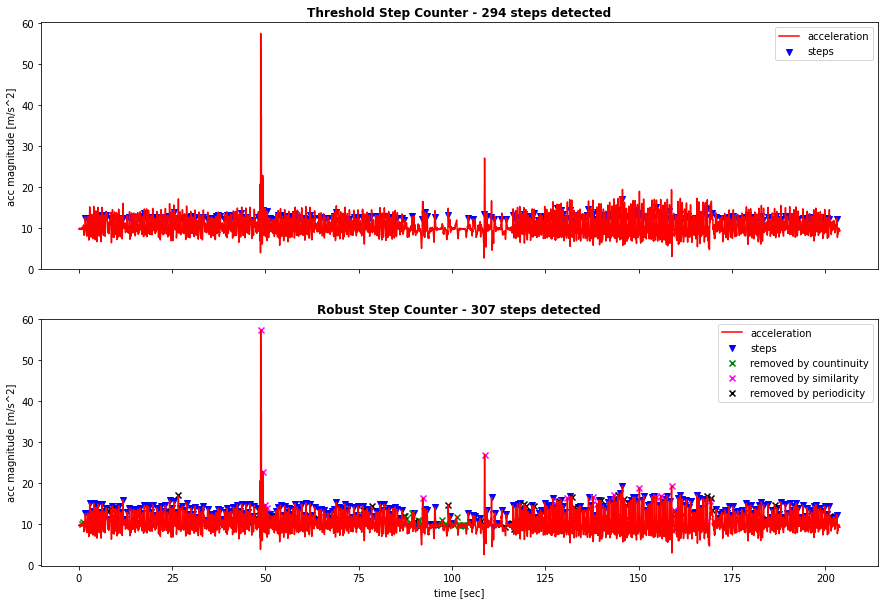

In [14]:
print(thresholdStepCounter)
# plot accelerations data in each axes
fig, axs = plt.subplots(nrows=2, ncols=1,sharex=True, figsize=(15,10))

axs[0].plot(np.arange(len(data))*sample_rate,data,'-r')
axs[0].scatter(threshold_steps*sample_rate,data[threshold_steps], c='blue', marker='v')
axs[0].set_ylabel('acc magnitude [m/s^2]')
axs[0].set_title('Threshold Step Counter - '+ str(len(threshold_steps))+ ' steps detected', fontweight='bold')
axs[0].legend(('acceleration','steps'))

axs[1].plot(np.arange(len(data))*sample_rate,data,'-r')
axs[1].scatter(robust_steps*sample_rate,data[robust_steps],c='blue',marker='v')
if countinuities.shape[0]>0:
    axs[1].scatter(countinuities*sample_rate,data[countinuities],c='green',marker='x')
if similarities.shape[0]>0:
    axs[1].scatter(similarities*sample_rate,data[similarities],c='magenta',marker='x')
if periodicities.shape[0]>0:
    axs[1].scatter(periodicities*sample_rate,data[periodicities],c='black',marker='x')
axs[1].set_ylabel('acc magnitude [m/s^2]')
axs[1].set_title('Robust Step Counter - '+ str(len(robust_steps))+ ' steps detected', fontweight='bold')
axs[1].legend(('acceleration','steps','removed by countinuity', 'removed by similarity', 'removed by periodicity'))


axs[1].set_xlabel('time [sec]')

plt.show()